# Study the percentages and their relationship with the metrics 


In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import sys
sys.path.append("..")
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
from utils.plots import plot_label_distribution_datasets
from utils.helpers_config import set_up_config, save_config
from utils.helpers_testing import get_test_stats_from_model, load_test_dataset, save_test_stats
from utils.plots_test import plots_all_figs_at_test
import matplotlib.pyplot as plt
from utils.test.load_model import get_all_runs, get_loaded_model_and_criterion, get_model_and_model_path
from utils.helpers_mu import get_mus_from_config
from utils.results_analysis.extract_video import download_images, add_files_to_images, save_video
import argparse
import seaborn as sns


In [3]:
local_dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
entity, project = "aurenore", "MasterThesis"
sweep = "piecewise_lin_regr_with_wrong_pred_penalties_5"
# save dir is the current directory plus artifacts plus sweeps plus sweep 
save_dir = os.path.join("artifacts", "sweeps", sweep)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
print("save_dir:", save_dir)

save_dir: artifacts\sweeps\piecewise_lin_regr_with_wrong_pred_penalties_5


load the runs of the sweep 

In [4]:
print("Local dataroot: ", local_dataroot)

# ## Download the model from wandb 
runs_df, runs = get_all_runs(entity, project)

# get the runs from the sweep 
df = runs_df[runs_df.sweep == sweep]
print("number of runs: ", len(df))  
df.head()

Local dataroot:  C:\Users\anyam\elects_data
number of runs:  156


,summary,config,name,sweep,start_date
0,"{'wrong_pred_penalty': 14.22607135772705, 'alp...","{'mu': 150, 'mus': [92, 72, 25, 102, 150, 150,...",easy-sweep-156,piecewise_lin_regr_with_wrong_pred_penalties_5,2024-06-22T06:19:52
1,"{'_timestamp': 1719041661.4066217, 'loss': {'t...","{'mu': 150, 'mus': [104, 37, 25, 102, 150, 104...",atomic-sweep-155,piecewise_lin_regr_with_wrong_pred_penalties_5,2024-06-22T05:58:10
2,"{'lin_regr_zt_loss': 0.7854890823364258, 'labe...","{'mu': 150, 'mus': [103, 94, 26, 104, 150, 150...",deep-sweep-154,piecewise_lin_regr_with_wrong_pred_penalties_5,2024-06-22T05:50:16
3,"{'_step': 62, 'recall': 0.5453709274350962, 'h...","{'mu': 150, 'mus': [168, 104, 104, 145, 150, 1...",iconic-sweep-153,piecewise_lin_regr_with_wrong_pred_penalties_5,2024-06-22T05:41:39
4,"{'label_distribution': {'width': 1500, 'format...","{'mu': 150, 'mus': [103, 74, 25, 103, 150, 150...",hardy-sweep-152,piecewise_lin_regr_with_wrong_pred_penalties_5,2024-06-22T05:15:39


In [5]:
df.config[0]

{'mu': 150,
 'mus': [92, 72, 25, 102, 150, 150, 145],
 'loss': 'daily_reward_piecewise_lin_regr',
 'alpha': 1,
 'device': 'cuda',
 'epochs': 100,
 'factor': 'v2',
 'resume': False,
 'dataset': 'breizhcrops',
 'epsilon': 10,
 'dataroot': '/home/amauron/elects/data/elects_data',
 'p_thresh': 0.5,
 'patience': 30,
 'snapshot': '/home/amauron/elects/data/elects_snapshots/model.pth',
 'batchsize': 256,
 'corrected': True,
 'alpha_decay': [1, 0.7],
 'hidden_dims': 64,
 'loss_weight': 'balanced',
 'left_padding': False,
 'weight_decay': 0,
 'backbonemodel': 'LSTM',
 'class_weights': [0.04731182754039765,
  0.02670983411371708,
  0.14316703379154205,
  0.01290007308125496,
  1,
  0.011567785404622557,
  0.010797104798257353],
 'decision_head': 'day',
 'learning_rate': 0.001,
 'nb_parameters': 66978,
 'sequencelength': 365,
 'validation_set': 'valid',
 'daily_timestamps': True,
 'day_head_init_bias': None,
 'extra_padding_list': [0],
 'percentage_alpha_1': '0.46788844',
 'percentage_alpha_2': '

The loss is written as:

$$ \alpha_1 C_m - \alpha_2 C_d + \alpha_3 C_{penalty} + \alpha_4 C_{lr} $$
where 
- $C_m$ is the misclassification cost 
- $C_d$ is the earliness reward
- $C_{penalty}$ is the early wrong prediction penalty
- $C_{lr}$ is the piecewise linear regression cost
- $\alpha_i$ are the weights for $i=1,2,3,4$

$\alpha_1$ is fixed at 1. at the beginning of the training and decays linearly through the training. The other alphas are given by a their corresponding percentage $p_{\alpha_i}$ and the current value of $\alpha_1$ as follows:
$$ \alpha_i = p_{\alpha_i} (1 - \alpha_1)$$

That way the sum of the weights is always 1.

In [6]:
metrics = ["fscore", "accuracy", "earliness", "harmonic_mean"]
metrics_summary = ["fscore", "accuracy", "elects_earliness", "harmonic_mean"]
metrics_labels = ["F1-score", "Accuracy", "Earliness", "Harmonic mean"]

In [7]:
df.loc[:, "percentages_alphas"] = df.loc[:, "config"].apply(lambda x: x["percentages_other_alphas"])
df.loc[:, "percentage_alpha_1"] = df.loc[:, "percentages_alphas"].apply(lambda x: x[0])
df.loc[:, "percentage_alpha_2"] = df.loc[:, "percentages_alphas"].apply(lambda x: x[1])
df.loc[:, "percentage_alpha_3"] = df.loc[:, "percentages_alphas"].apply(lambda x: x[2])
df.loc[:, "alphas"] = df.loc[:, "summary"].apply(lambda x: x["alphas"])

for i, metric in enumerate(metrics):
    df.loc[:, metric] = df.loc[:, "summary"].apply(lambda x: x[metrics_summary[i]])

C:\Users\anyam\AppData\Local\Temp\ipykernel_5020\3505622809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "percentages_alphas"] = df.loc[:, "config"].apply(lambda x: x["percentages_other_alphas"])
C:\Users\anyam\AppData\Local\Temp\ipykernel_5020\3505622809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "percentage_alpha_1"] = df.loc[:, "percentages_alphas"].apply(lambda x: x[0])
C:\Users\anyam\AppData\Local\Temp\ipykernel_5020\3505622809.py:3: SettingWithCopyWarning: 
A value 

In [8]:
df["alphas"]

0      [0.699999988079071, 0.1403665393590927, 0.0516...
1      [0.5, 0.2310073971748352, 0.13317464292049408,...
2      [0.699999988079071, 0.15017226338386536, 0.042...
3      [0.8166666626930237, 0.06006983667612076, 0.08...
4      [0.5, 0.2927127480506897, 0.1455155462026596, ...
                             ...                        
151    [0.928749978542328, 0.02986699342727661, 0.022...
152    [0.5, 0.2595651149749756, 0.21413607895374295,...
153    [0.7734693884849548, 0.09724846482276917, 0.12...
154    [0.9211111068725586, 0.04854246601462364, 0.00...
155    [0.5, 0.36963504552841187, 0.00680588278919458...
Name: alphas, Length: 156, dtype: object

# Correlations between the percentages and the metrics
metrics : 
- accuracy 
- earliness
- harmonic mean of accuracy and earliness

In [27]:
percentages_alphas = ["percentage_alpha_1", "percentage_alpha_2", "percentage_alpha_3"]
percentages_alphas_labels = ["% alpha 2", "% alpha 3", "% alpha 4"]
print(percentages_alphas_labels)

['% alpha 2', '% alpha 3', '% alpha 4']


In [28]:
df_correlations = df[percentages_alphas+metrics].corr()
df_correlations.loc[percentages_alphas,metrics]

,fscore,accuracy,earliness,harmonic_mean
percentage_alpha_1,-0.070817,-0.049796,0.091245,0.025069
percentage_alpha_2,-0.583120,-0.604742,0.614223,-0.487361
percentage_alpha_3,0.667080,0.667487,-0.719793,0.470847


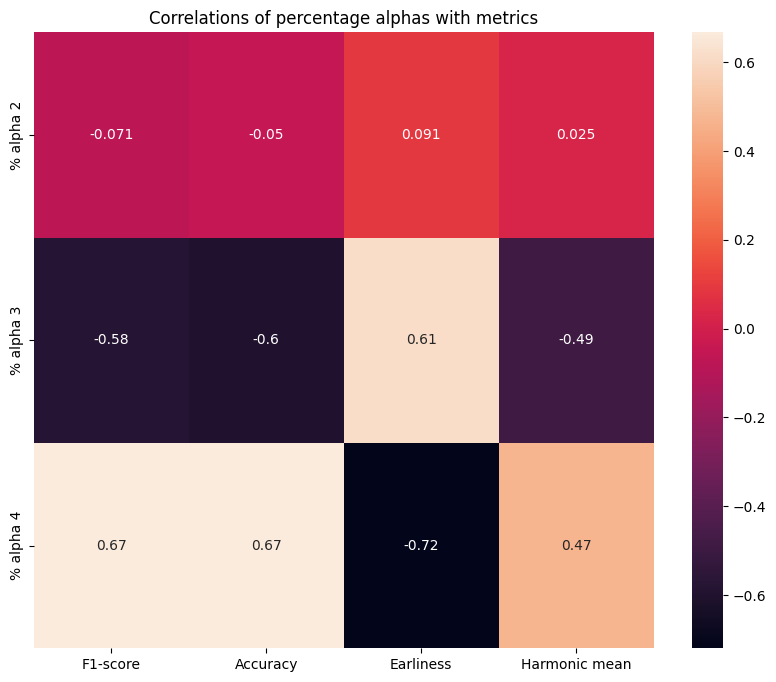

In [29]:
# create heatmap of correlations of percentage alphas with metrics
plt.figure(figsize=(10, 8))
sns.heatmap(df_correlations.loc[percentages_alphas,metrics], annot=True, xticklabels=metrics_labels, yticklabels=percentages_alphas_labels)
plt.title("Correlations of percentage alphas with metrics")
plt.savefig(os.path.join(save_dir, "correlations_percentage_alphas_with_metrics.png"))

with alphas: 

In [10]:
alphas = ["alpha_1", "alpha_2", "alpha_3", "alpha_4"]
alphas_labels = [r"$\alpha_1$", r"$\alpha_2$", r"$\alpha_3$", r"$\alpha_4$"]


In [11]:
df_alphas = df[["alphas"]+metrics]
for i, alpha in enumerate(alphas):
    df_alphas.loc[:, alpha] = df_alphas.loc[:, "alphas"].apply(lambda x: x[i])

C:\Users\anyam\AppData\Local\Temp\ipykernel_5020\3214042273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alphas.loc[:, alpha] = df_alphas.loc[:, "alphas"].apply(lambda x: x[i])
C:\Users\anyam\AppData\Local\Temp\ipykernel_5020\3214042273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alphas.loc[:, alpha] = df_alphas.loc[:, "alphas"].apply(lambda x: x[i])
C:\Users\anyam\AppData\Local\Temp\ipykernel_5020\3214042273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [12]:
df_corr_alphas = df_alphas[alphas+metrics].corr() # pearson correlation
df_corr_alphas.loc[alphas,metrics]

,fscore,accuracy,earliness,harmonic_mean
alpha_1,-0.160233,-0.236159,0.143932,-0.251471
alpha_2,0.003157,0.068153,-0.005211,0.112651
alpha_3,-0.215773,-0.170240,0.250382,-0.089593
alpha_4,0.445314,0.484396,-0.436347,0.408378


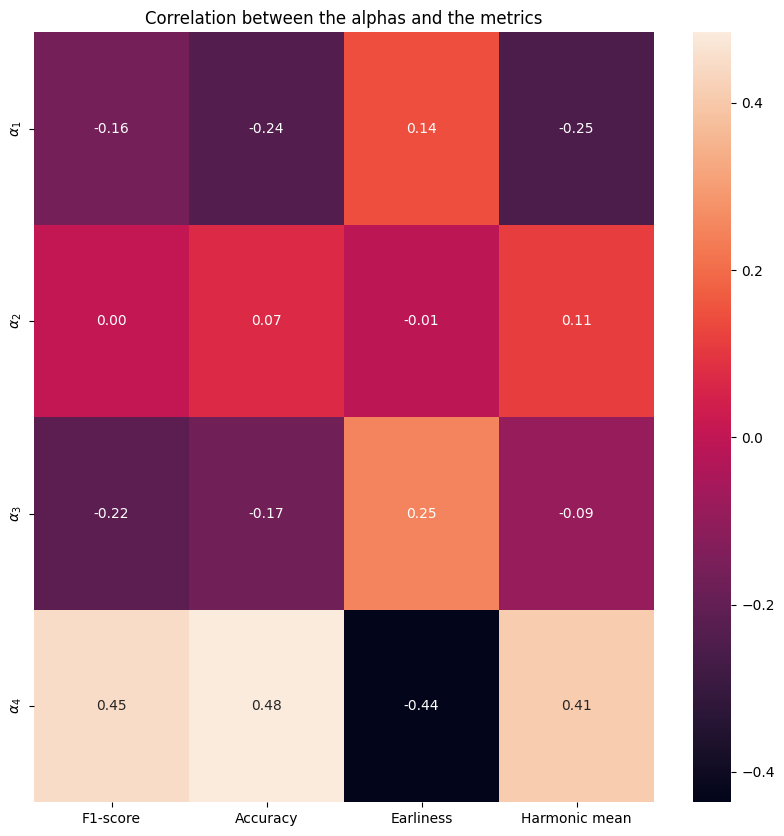

In [13]:
# create a heatmap of the correlation matrix 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_corr_alphas.loc[alphas,metrics], annot=True, fmt=".2f", xticklabels=metrics_labels, yticklabels=alphas_labels, ax=ax)
plt.title("Correlation between the alphas and the metrics")
plt.show()
# save fig 
fig.savefig(os.path.join(save_dir, "correlation_alphas_metrics.png"))



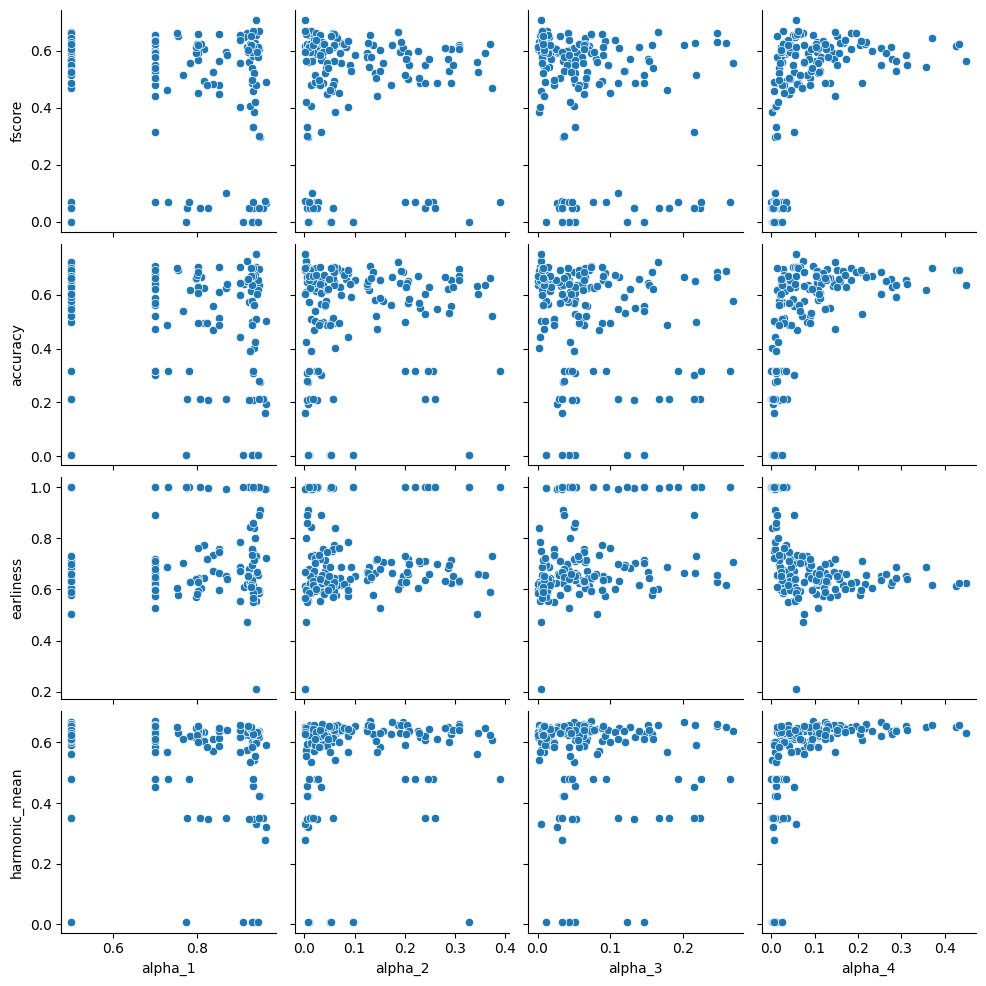

In [14]:
# pairplot of the alphas and the metrics
import seaborn as sns
sns.pairplot(df_alphas, x_vars=alphas, y_vars=metrics, diag_kind="kde")
plt.savefig(os.path.join(save_dir, "pairplot_alphas_metrics.png"))

<Figure size 1000x1000 with 0 Axes>

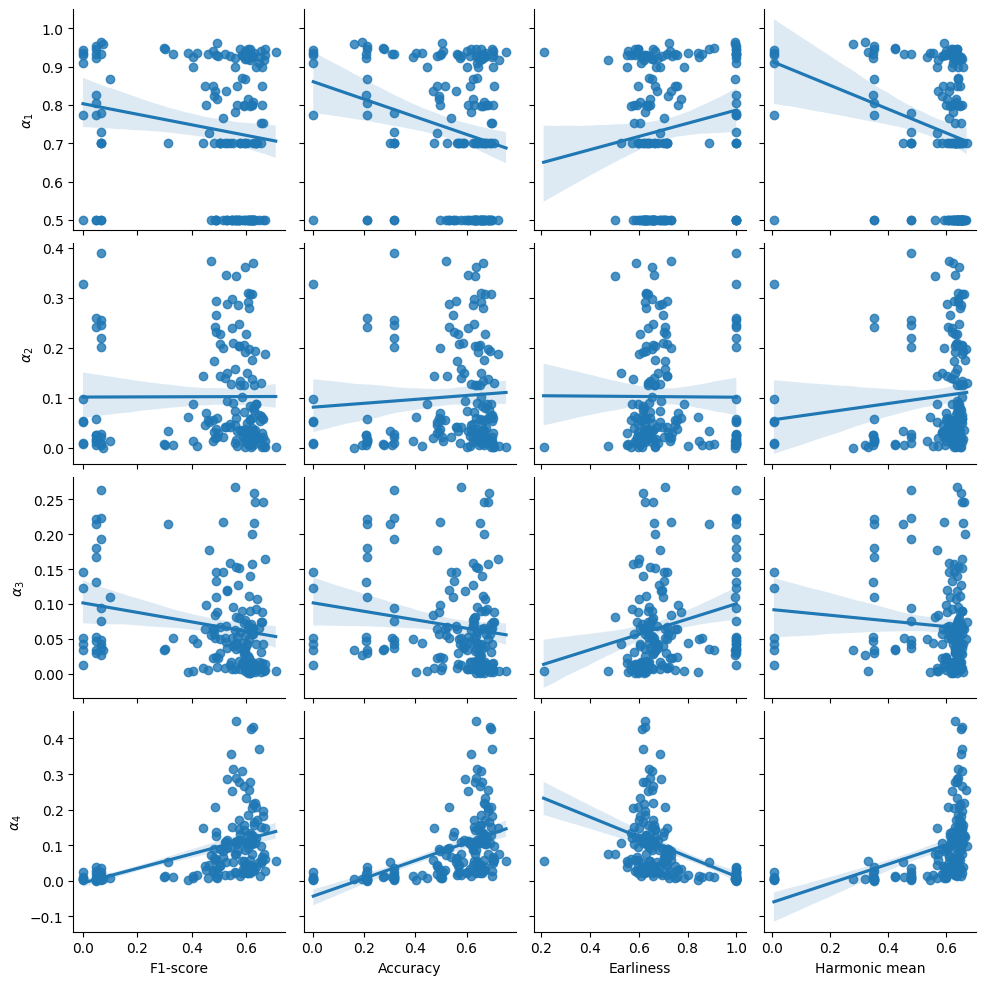

In [15]:
# pairplot of the alphas and the metrics
import seaborn as sns
plt.figure(figsize=(10,10))
g = sns.pairplot(df_alphas, y_vars=alphas, x_vars=metrics, kind="reg")
# set x and y labels
for i in range(4):
    for j in range(4):
        g.axes[i,j].set_xlabel(metrics_labels[j])
        g.axes[i,j].set_ylabel(alphas_labels[i])
        
    
plt.savefig(os.path.join(save_dir, "pairplot_alphas_metrics_reg.png"))

# Test

In [16]:
hue = "start_decision_head_training"
# add the hue to the df_alphas, which is in the df
df_alphas_hue = df_alphas.copy()
df_alphas_hue.loc[:, hue] = df.loc[:, "config"].apply(lambda x: x[hue])

<Figure size 1000x1000 with 0 Axes>

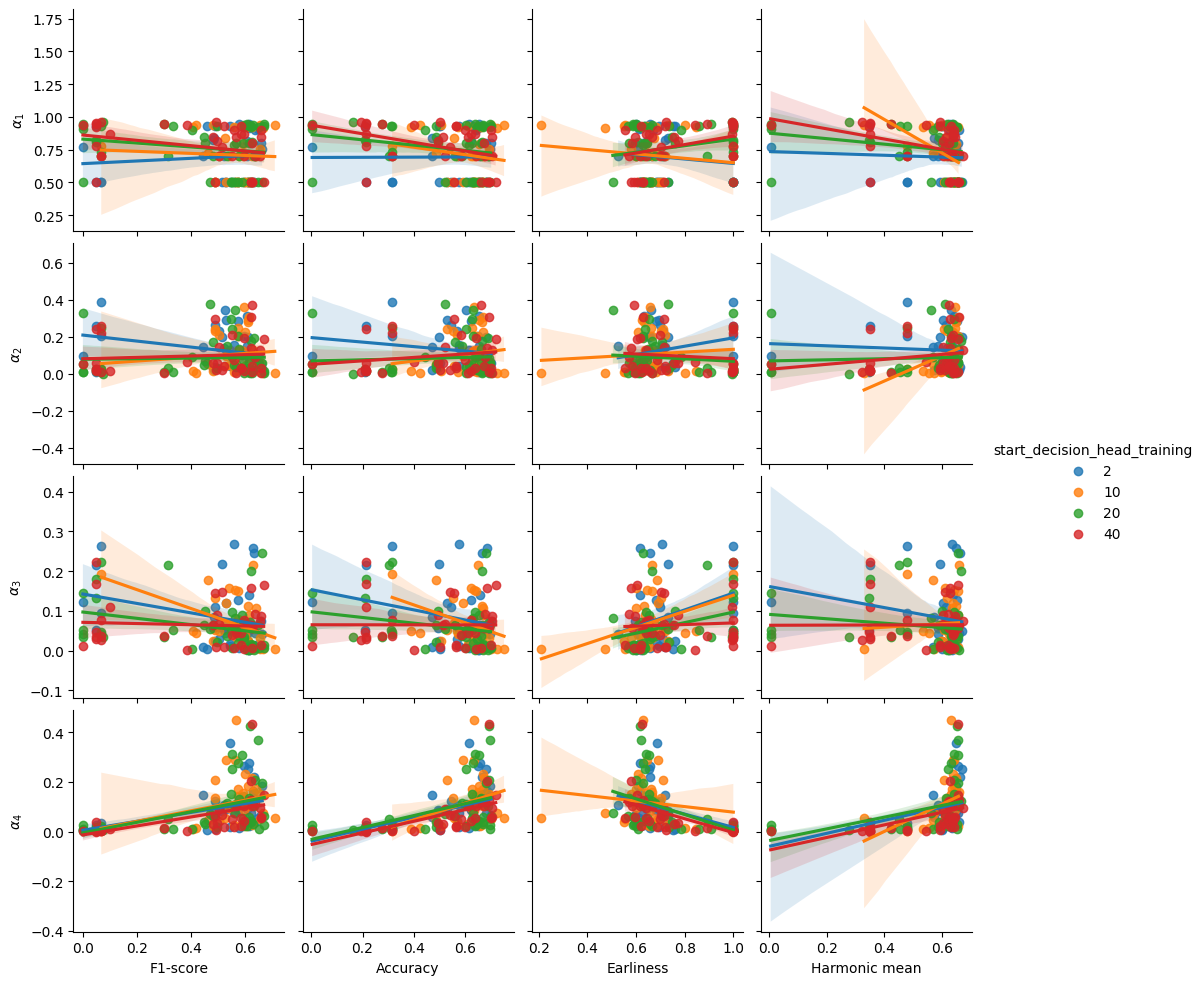

In [17]:
# pairplot of the alphas and the metrics
import seaborn as sns
plt.figure(figsize=(10,10))
g = sns.pairplot(df_alphas_hue, y_vars=alphas, x_vars=metrics, hue=hue, kind="reg")
# set x and y labels
for i in range(4):
    for j in range(4):
        g.axes[i,j].set_xlabel(metrics_labels[j])
        g.axes[i,j].set_ylabel(alphas_labels[i])
        
# g.map_lower(sns.kdeplot, levels=4, color=".2")

# plt.savefig(os.path.join(save_dir, "pairplot_alphas_metrics_test.png"))

<Figure size 1000x1000 with 0 Axes>

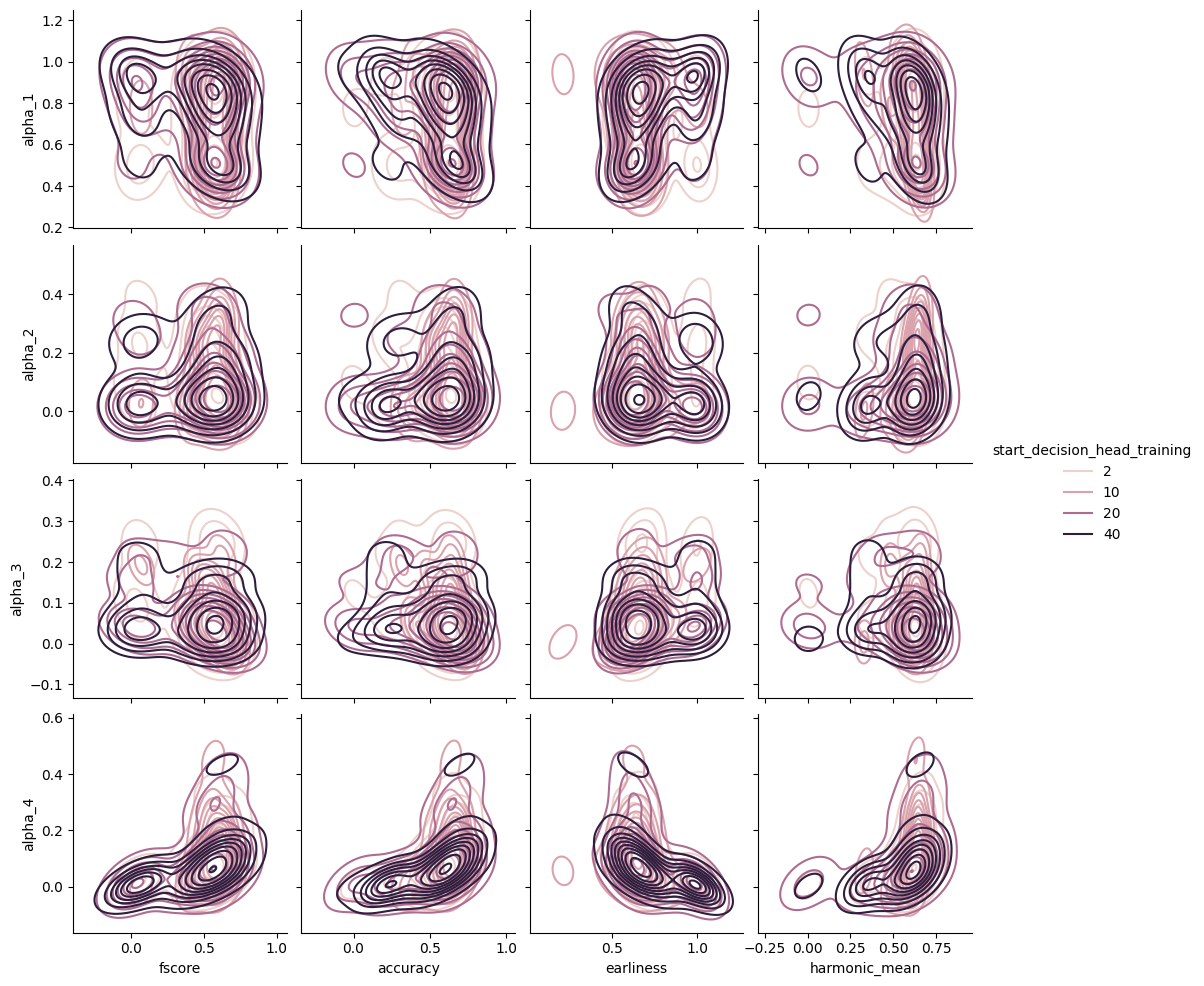

In [18]:
import seaborn as sns
plt.figure(figsize=(10,10))
g = sns.pairplot(df_alphas_hue, y_vars=alphas, x_vars=metrics, kind="kde", hue=hue)

# Select the best model 
the model with the highest harmonic mean 


In [19]:
from utils.test.load_model import get_best_run
run = get_best_run(df, runs, metric="harmonic_mean")

chosen run:  feasible-sweep-121
with harmonic_mean:  0.671445685320627


In [20]:
# get the value alphas from the summary, for each eporch 
run_alphas = run.summary["alphas"]

print("alpha_1*misclassifications: ", run_alphas[0]*run.summary["classification_loss"])
print("alpha_2*earliness_reward: ", run_alphas[1]*run.summary["earliness_reward"])
print("alpha_3*wrong_pred_penalty: ", run_alphas[2]*run.summary["wrong_pred_penalty"])
print("alpha_4*piecewise_lin_regr: ", run_alphas[3]*run.summary["lin_regr_zt_loss"])

alpha_1*misclassifications:  7.059981225899605
alpha_2*earliness_reward:  0.3349031722615692
alpha_3*wrong_pred_penalty:  0.33297584881624687
alpha_4*piecewise_lin_regr:  0.054115156769030115
